# Introduction

In this session, we will demonstrate how to insert data into and query data from MongoDb databases. Specifically, we will be working with a truncated set of data from Chu, I.-H. et al. Room-Temperature All-solid-state Rechargeable Sodium-ion Batteries with a Cl-doped Na3PS4 Superionic Conductor. Sci. Rep. 2016, 6, 33733.

Let us first load the data we are going to insert.

In [1]:
import json
from monty.io import zopen

with zopen("trajectories.json.gz") as f:
    data = json.load(f)

print("There are %d documents." % len(data))
print("A sample document : ")
print(json.dumps(data[0], indent=4))

There are 4503 documents.
A sample document : 
{
    "md_id": 116,
    "config_id": 1,
    "start_temp": 800.0,
    "end_temp": 800.0,
    "step": 50000,
    "structure": {
        "lattice": [
            [
                13.979387,
                -0.001914,
                0.002221
            ],
            [
                -0.001913,
                13.984569,
                0.005579
            ],
            [
                0.002258,
                0.005674,
                14.267596
            ]
        ],
        "frac_coords": [
            [
                0.00948583,
                0.49121155,
                0.4945422
            ],
            [
                0.01451769,
                0.26874781,
                0.83014042
            ],
            [
                0.00276345,
                0.75394127,
                0.48910468
            ],
            [
                0.96290093,
                0.77977741,
                0.95077518
            ],
 

# Inserting the data into a MongoDB database

We will use pymongo, a Python interface to MongoDB. Note that you will not be able to do the data insertion. 

In [2]:
from pymongo import MongoClient, ASCENDING

In [3]:
# These few lines connects to the database that has been setup for this workshop.
client = MongoClient("ds141786.mlab.com", port=41786)
db = client.trajectories
db.authenticate("user", "miguest")
traj = db.trajectories

# These two lines insert the data into the MongoDB database.
# traj.ensure_index("step")
# traj.insert_many(data)

# Getting the data from the MongoDB database

We will now query the data back from the MongoDB database. To make life easier, let us specify a function to get the data from a specific temperature. Here, we will make use of pymatgen.analysis.diffusion_analyzer.DiffusionAnalyzer to calculate diffusivity from the mean square displacements.

In [4]:
from pymatgen import Structure
from pymatgen.analysis.diffusion_analyzer import DiffusionAnalyzer
Na3PS4Cl = Structure.from_file("Cl_doped_Na3PS4/Na47P16S63Cl1_0/Na47P16S63Cl1.cif")
Na3PS4Cl.remove_oxidation_states()

def get_diffusivity_analyzer(temp, time_step, step_skip, use_db=True):
    
    species = Na3PS4Cl.species 
    if use_db:
        crit = {"step": {"$mod": [step_skip, 0], "$gte": 50000},
                "md_id": 116, "end_temp": temperature,
                "config_id": 1}
        structures = []
        for r in traj.find(crit, projection=["structure", "step"], sort=[("step", ASCENDING)]):
            structures.append(Structure(r["structure"]["lattice"], species, r["structure"]["frac_coords"]))
        a = DiffusionAnalyzer.from_structures(structures, "Na", temperature=temperature, 
                                              time_step=time_step, step_skip=step_skip, smoothed=False)
        return a
    else:
        # This is a backup that queries the data from the loaded file in case connection to the MongoDB
        # does not work during the workshop.
        temp_data = [d for d in data if d["end_temp"] == temp]
        temp_data.sort(key=lambda d: d["step"])
        structures = []
        for d in temp_data:
            structures.append(Structure(d["structure"]["lattice"], species, d["structure"]["frac_coords"]))
        a = DiffusionAnalyzer.from_structures(structures, "Na", temperature=temperature, 
                                              time_step=time_step, step_skip=step_skip, smoothed=False)
        return a

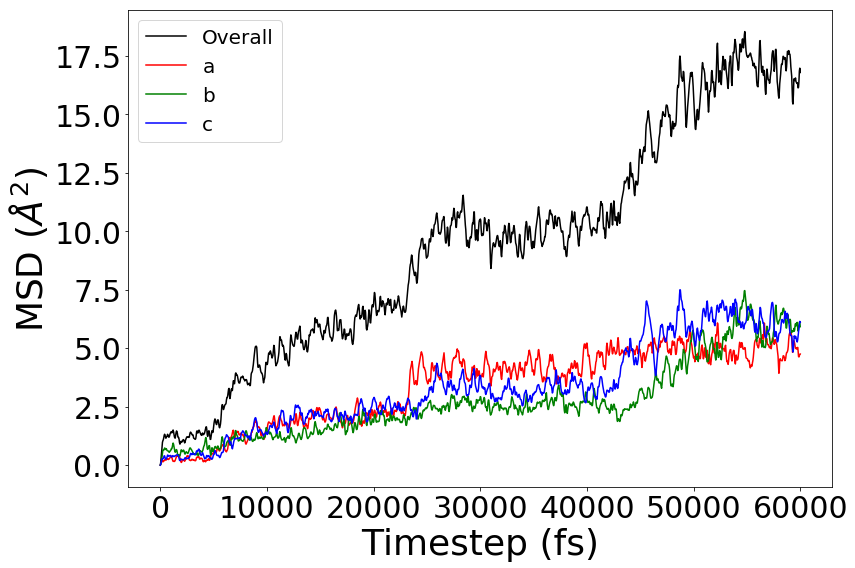

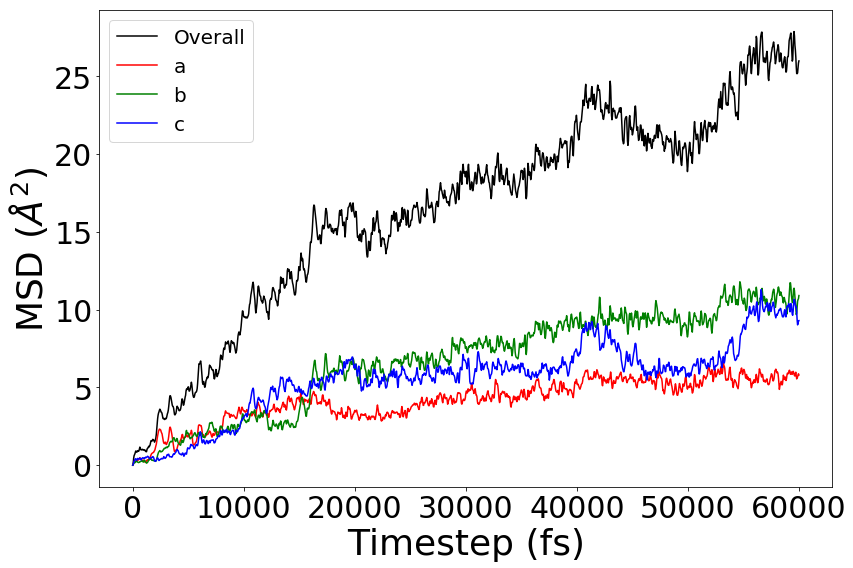

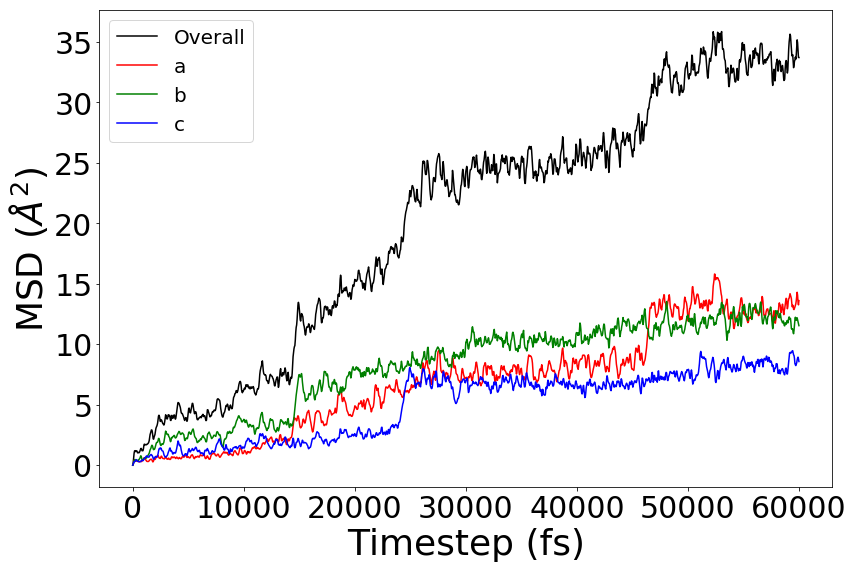

In [5]:
%matplotlib inline
step_skip = 20
time_step = 2
diffusivities = []
for temperature in [800, 1000, 1200]:
    da = get_diffusivity_analyzer(temperature, time_step, step_skip)
    da.plot_msd()
    diffusivities.append(da.diffusivity)

# Plotting the Arrhenius plot and extrapolating the conductivity

Pymatgen provides tools to plot the Arrhenius plot and extrapolate the conductivity from a set of temperatures and corresponding diffusivities.

/Users/shyue/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<module 'matplotlib.pyplot' from '/Users/shyue/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

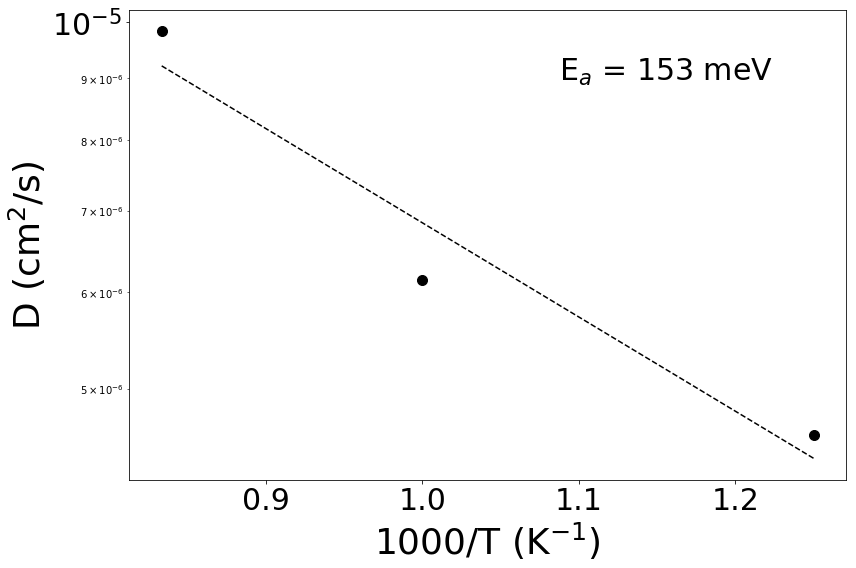

In [6]:
from pymatgen.analysis.diffusion_analyzer import get_arrhenius_plot, get_extrapolated_conductivity

plt = get_arrhenius_plot([800, 1000, 1200], diffusivities)

Finally, we can compute the conductivity at room temperature.

In [7]:
print("The extrapolated conductivity at 300K is %.1f mS/cm" % 
      get_extrapolated_conductivity([800, 1000, 1200], diffusivities, 300, Na3PS4Cl, "Na"))

The extrapolated conductivity at 300K is 11.4 mS/cm


It should be noted that this value will differ significantly from the value reported in the previous work. The reason is that we have only used a relatively few number of trajectories, and only three temperatures to perform the analysis. For high-quality analysis, a minimum of five temperatures and much longer trajectories (at least 100 ps at lower temperatures) should be used.